# Projeto 8: Classificação de sinais de trânsito

Arquitetura LeNet: http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf

# Etapa 1: Importação das bibliotecas

In [ ]:
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import tensorflow as tf
import pandas as pd
import seaborn as sns
import pickle
import zipfile
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.15.0'

# Etapa 2: Importação da base de dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/traffic-signs-data.zip'#Dataset directory
zip_object = zipfile.ZipFile(file=path, mode='r')#Read the zip file
zip_object.extractall('./')#Extract it
zip_object.close()#Close the zip object

In [ ]:
with open('/content/traffic-signs-data/train.p', mode='rb') as training_data:#Read the training data
  train = pickle.load(training_data)
with open('/content/traffic-signs-data/test.p', mode='rb') as testing_data:#Read the test data
  test = pickle.load(testing_data)
with open('/content/traffic-signs-data/valid.p', mode='rb') as validation_data:#Read the validation data
  valid = pickle.load(validation_data)

In [ ]:
train

{'coords': array([[  6,   5,  21,  20],
        [  6,   6,  22,  22],
        [  5,   6,  22,  23],
        ...,
        [ 17,  15, 178, 155],
        [ 17,  15, 183, 160],
        [ 20,  18, 211, 184]], dtype=uint8),
 'labels': array([41, 41, 41, ..., 25, 25, 25], dtype=uint8),
 'features': array([[[[ 28,  25,  24],
          [ 27,  24,  23],
          [ 27,  24,  22],
          ...,
          [ 32,  28,  24],
          [ 31,  27,  25],
          [ 31,  27,  26]],
 
         [[ 29,  26,  25],
          [ 27,  25,  23],
          [ 27,  25,  23],
          ...,
          [ 32,  28,  24],
          [ 31,  27,  24],
          [ 30,  27,  25]],
 
         [[ 28,  26,  26],
          [ 27,  25,  23],
          [ 26,  25,  23],
          ...,
          [ 32,  28,  24],
          [ 31,  27,  24],
          [ 30,  27,  25]],
 
         ...,
 
         [[ 27,  24,  23],
          [ 28,  25,  24],
          [ 30,  25,  24],
          ...,
          [ 27,  24,  23],
          [ 28,  24,  22],
  

In [ ]:
X_train, y_train = train['features'], train['labels']#Read the labels and the features of the signals
X_test, y_test = test['features'], test['labels']#Read the labels and the features of the signals
X_validation, y_validation = valid['features'], valid['labels']#Read the labels and the features of the signals

In [ ]:
X_train.shape

(34799, 32, 32, 3)

In [ ]:
y_train.shape

(34799,)

In [ ]:
X_test.shape

(12630, 32, 32, 3)

In [ ]:
X_validation.shape

(4410, 32, 32, 3)

# Etapa 3: Visualização dos dados

1

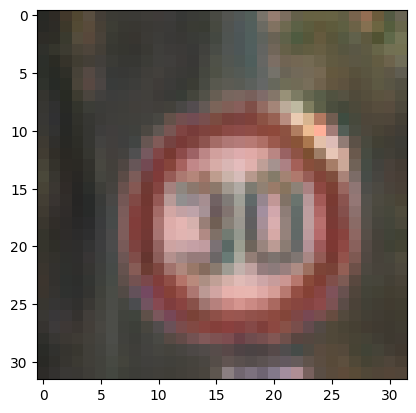

In [ ]:
i = 3100
plt.imshow(X_train[i])
y_train[i]

36

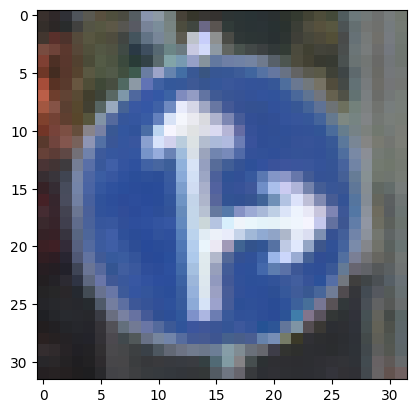

In [ ]:
i = 3001
plt.imshow(X_test[i])
y_test[i]

8

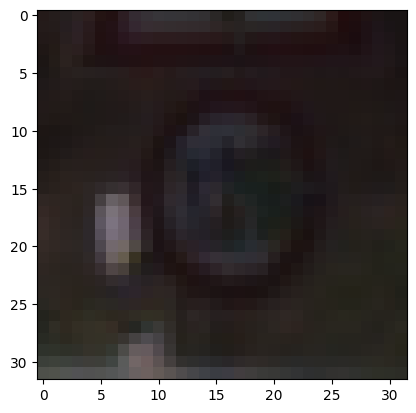

In [ ]:
i = 2100
plt.imshow(X_validation[i])
y_validation[i]

# Etapa 4: Preparação dos dados

In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)#Mix the dataset randomlly

In [ ]:
#Convert from RGB to the gray scale
#np.sum(dataset / 3, axis = 3, keepdims=True)
#dataset / 3 => Divide each pixel of RGB by 3
#axis = 3 => function is applied across the fourth axis (axis=3), which is the channel axis in the RGB image.
# keepdims=True => This parameter retains the dimensionality of the resulting array
X_train_gray = np.sum(X_train / 3, axis = 3, keepdims=True)
X_test_gray = np.sum(X_test / 3, axis = 3, keepdims=True)
X_validation_gray = np.sum(X_validation / 3, axis = 3, keepdims=True)

In [ ]:
X_train_gray.shape

(34799, 32, 32, 1)

In [ ]:
X_test_gray.shape

(12630, 32, 32, 1)

In [ ]:
X_validation_gray.shape

(4410, 32, 32, 1)

In [ ]:
#Put the data in -1 to 1 scale
X_train_gray_norm = (X_train_gray - 128) / 128
X_test_gray_norm = (X_test_gray - 128) / 128
X_validation_gray_norm = (X_validation_gray - 128) / 128

In [ ]:
np.max(X_train_gray_norm)

0.9921875

In [ ]:
np.min(X_train_gray_norm)

-0.9713541666666666

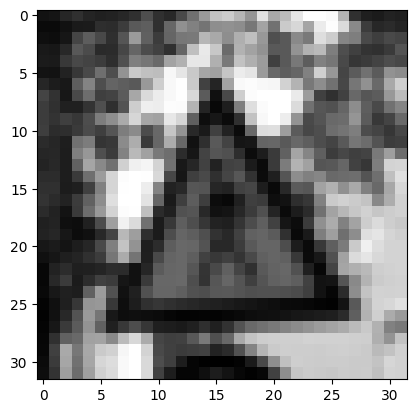

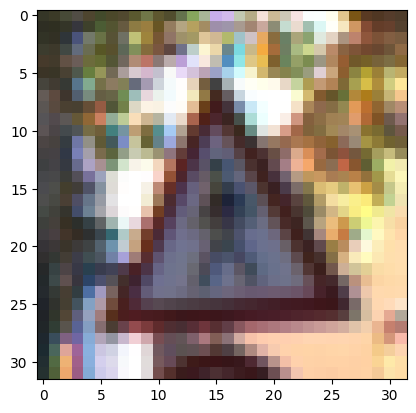

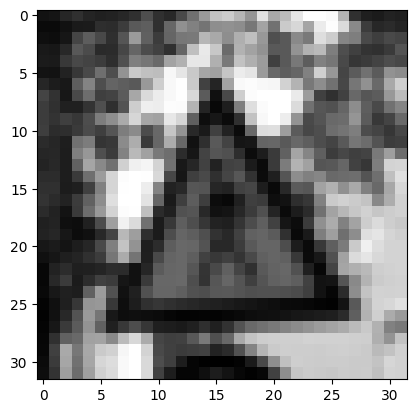

In [ ]:
i = 60
plt.imshow(X_train_gray[i].squeeze(), cmap='gray')
plt.figure()
plt.imshow(X_train[i])
plt.figure()
plt.imshow(X_train_gray_norm[i].squeeze(), cmap = 'gray')

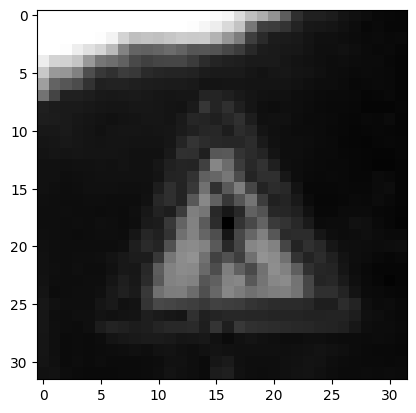

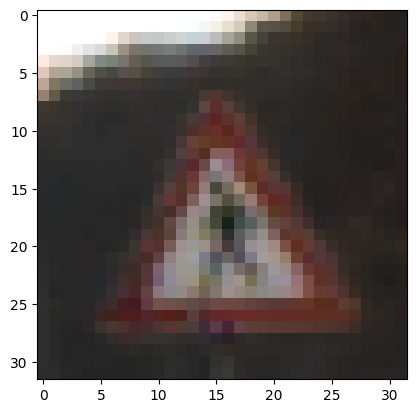

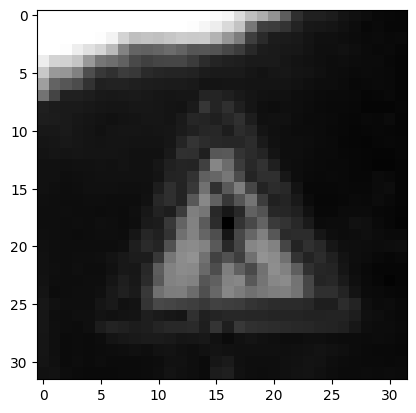

In [ ]:
i = 610
plt.imshow(X_test_gray[i].squeeze(), cmap='gray')
plt.figure()
plt.imshow(X_test[i])
plt.figure()
plt.imshow(X_test_gray_norm[i].squeeze(), cmap = 'gray')

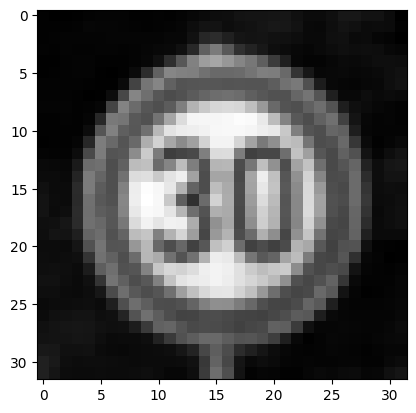

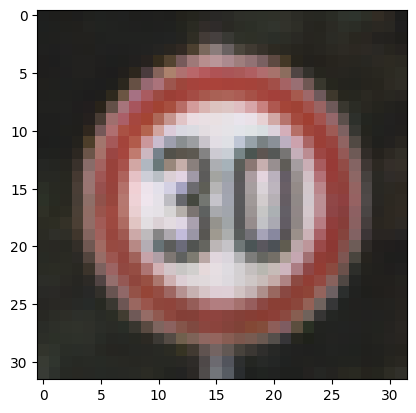

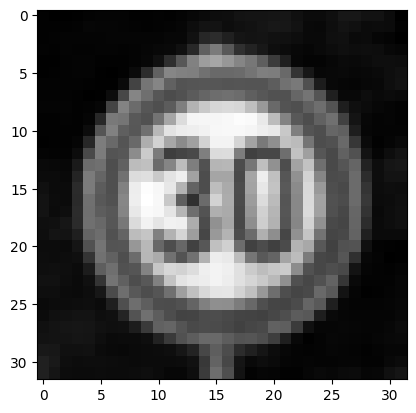

In [ ]:
i = 500
plt.imshow(X_validation_gray[i].squeeze(), cmap='gray')
plt.figure()
plt.imshow(X_validation[i])
plt.figure()
plt.imshow(X_validation_gray_norm[i].squeeze(), cmap = 'gray')

# Etapa 5: Criação do modelo e treinamento

- STEP 1: THE FIRST CONVOLUTIONAL LAYER #1
    - Input = 32x32x1
    - Output = 28x28x6
    - Output = (Input-filter+1)/Stride* => (32-5+1)/1=28
    - Used a 5x5 Filter with input depth of 3 and output depth of 6
    - Apply a RELU Activation function to the output
    - pooling for input, Input = 28x28x6 and Output = 14x14x6

- STEP 2: THE SECOND CONVOLUTIONAL LAYER #2
    - Input = 14x14x6
    - Output = 10x10x16
    - Layer 2: Convolutional layer with Output = 10x10x16
    - Output = (Input-filter+1)/strides => 10 = 14-5+1/1
    - Apply a RELU Activation function to the output
    - Pooling with Input = 10x10x16 and Output = 5x5x16

- STEP 3: FLATTENING THE NETWORK
    - Flatten the network with Input = 5x5x16 and Output = 400

- STEP 4: FULLY CONNECTED LAYER
    - Layer 3: Fully Connected layer with Input = 400 and Output = 120
    - Apply a RELU Activation function to the output

- STEP 5: ANOTHER FULLY CONNECTED LAYER
    - Layer 4: Fully Connected Layer with Input = 120 and Output = 84
    - Apply a RELU Activation function to the output

- STEP 6: FULLY CONNECTED LAYER
    - Layer 5: Fully Connected layer with Input = 84 and Output = 43

In [ ]:
from tensorflow.keras import layers, models

LeNet = models.Sequential()

LeNet.add(layers.Conv2D(6, (5,5), activation = 'relu', input_shape = (32, 32, 1)))#Convolutional layer
LeNet.add(layers.AveragePooling2D())#Apply the avarage pooling

LeNet.add(layers.Conv2D(16, (5,5), activation = 'relu'))#Convolutional layer
LeNet.add(layers.AveragePooling2D())#Apply the avarage pooling

LeNet.add(layers.Flatten())# Apply the flattening, transforming the matrix of the image in a array to the training

LeNet.add(layers.Dense(120, activation='relu'))#Dense layer

LeNet.add(layers.Dense(84, activation='relu'))#Dense layer

LeNet.add(layers.Dense(43, activation='softmax'))#Dense layer

LeNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [ ]:
LeNet.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = LeNet.fit(X_train_gray_norm, y_train,
                    batch_size = 500,
                    epochs = 50,
                    validation_data = (X_validation_gray_norm, y_validation))

Epoch 1/50
70/70 [==============================] - 2s 10ms/step - loss: 3.1998 - accuracy: 0.1777 - val_loss: 2.7977 - val_accuracy: 0.2658
Epoch 2/50
70/70 [==============================] - 0s 6ms/step - loss: 1.8041 - accuracy: 0.5074 - val_loss: 1.6054 - val_accuracy: 0.5420
Epoch 3/50
70/70 [==============================] - 0s 6ms/step - loss: 1.0233 - accuracy: 0.7094 - val_loss: 1.1067 - val_accuracy: 0.6950
Epoch 4/50
70/70 [==============================] - 0s 7ms/step - loss: 0.7214 - accuracy: 0.7950 - val_loss: 0.9923 - val_accuracy: 0.7288
Epoch 5/50
70/70 [==============================] - 1s 8ms/step - loss: 0.5623 - accuracy: 0.8450 - val_loss: 0.8610 - val_accuracy: 0.7785
Epoch 6/50
70/70 [==============================] - 1s 8ms/step - loss: 0.4709 - accuracy: 0.8712 - val_loss: 0.7651 - val_accuracy: 0.7946
Epoch 7/50
70/70 [==============================] - 1s 8ms/step - loss: 0.3973 - accuracy: 0.8927 - val_loss: 0.7397 - val_accuracy: 0.8061
Epoch 8/50
70/70 [=

# Etapa 6: Avaliação do modelo

In [ ]:
score = LeNet.evaluate(X_test_gray_norm, y_test)#Test the neural network
print('Test Accuracy: {}'.format(score[1]))

12630/12630 [==============================] - 1s 81us/sample - loss: 1.1308 - accuracy: 0.8683
Test Accuracy: 0.8682501912117004


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
accuracy = history.history['accuracy']#Get the accuracy data
val_accuracy = history.history['val_accuracy']#Get the validation accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
val_accuracy

[0.27596372,
 0.5609977,
 0.72471654,
 0.74580497,
 0.7786848,
 0.79818594,
 0.7984127,
 0.80453515,
 0.815873,
 0.8365079,
 0.84217685,
 0.837415,
 0.853288,
 0.8526077,
 0.84875286,
 0.8417234,
 0.8494331,
 0.85714287,
 0.84875286,
 0.844898,
 0.8489796,
 0.85555553,
 0.86145127,
 0.85056686,
 0.8634921,
 0.8646259,
 0.84126985,
 0.85918367,
 0.8639456,
 0.85668933,
 0.8668934,
 0.86099774,
 0.85555553,
 0.85510206,
 0.86190474,
 0.8709751,
 0.86326534,
 0.8761905,
 0.85283446,
 0.8675737,
 0.85056686,
 0.86145127,
 0.85918367,
 0.86213154,
 0.85895693,
 0.8659864,
 0.85374147,
 0.860771,
 0.8648526,
 0.8637188]

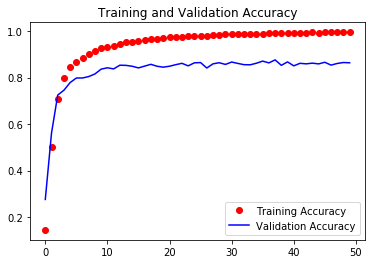

In [ ]:
#Show the accuracy according the epoch
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', color = 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend();

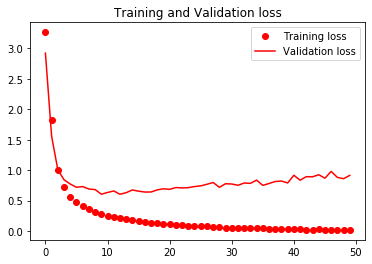

In [ ]:
#show the validation loss according the epoch
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend();

In [ ]:
predict_x = LeNet.predict(X_test_gray_norm)#Try predict using the test data
predicted_classes=np.argmax(predict_x,axis=1)#Put the predicted values in a numpy array
y_true = y_test

395/395 [==============================] - 1s 3ms/step


array([ 3, 10, 33, ..., 34, 33, 34])

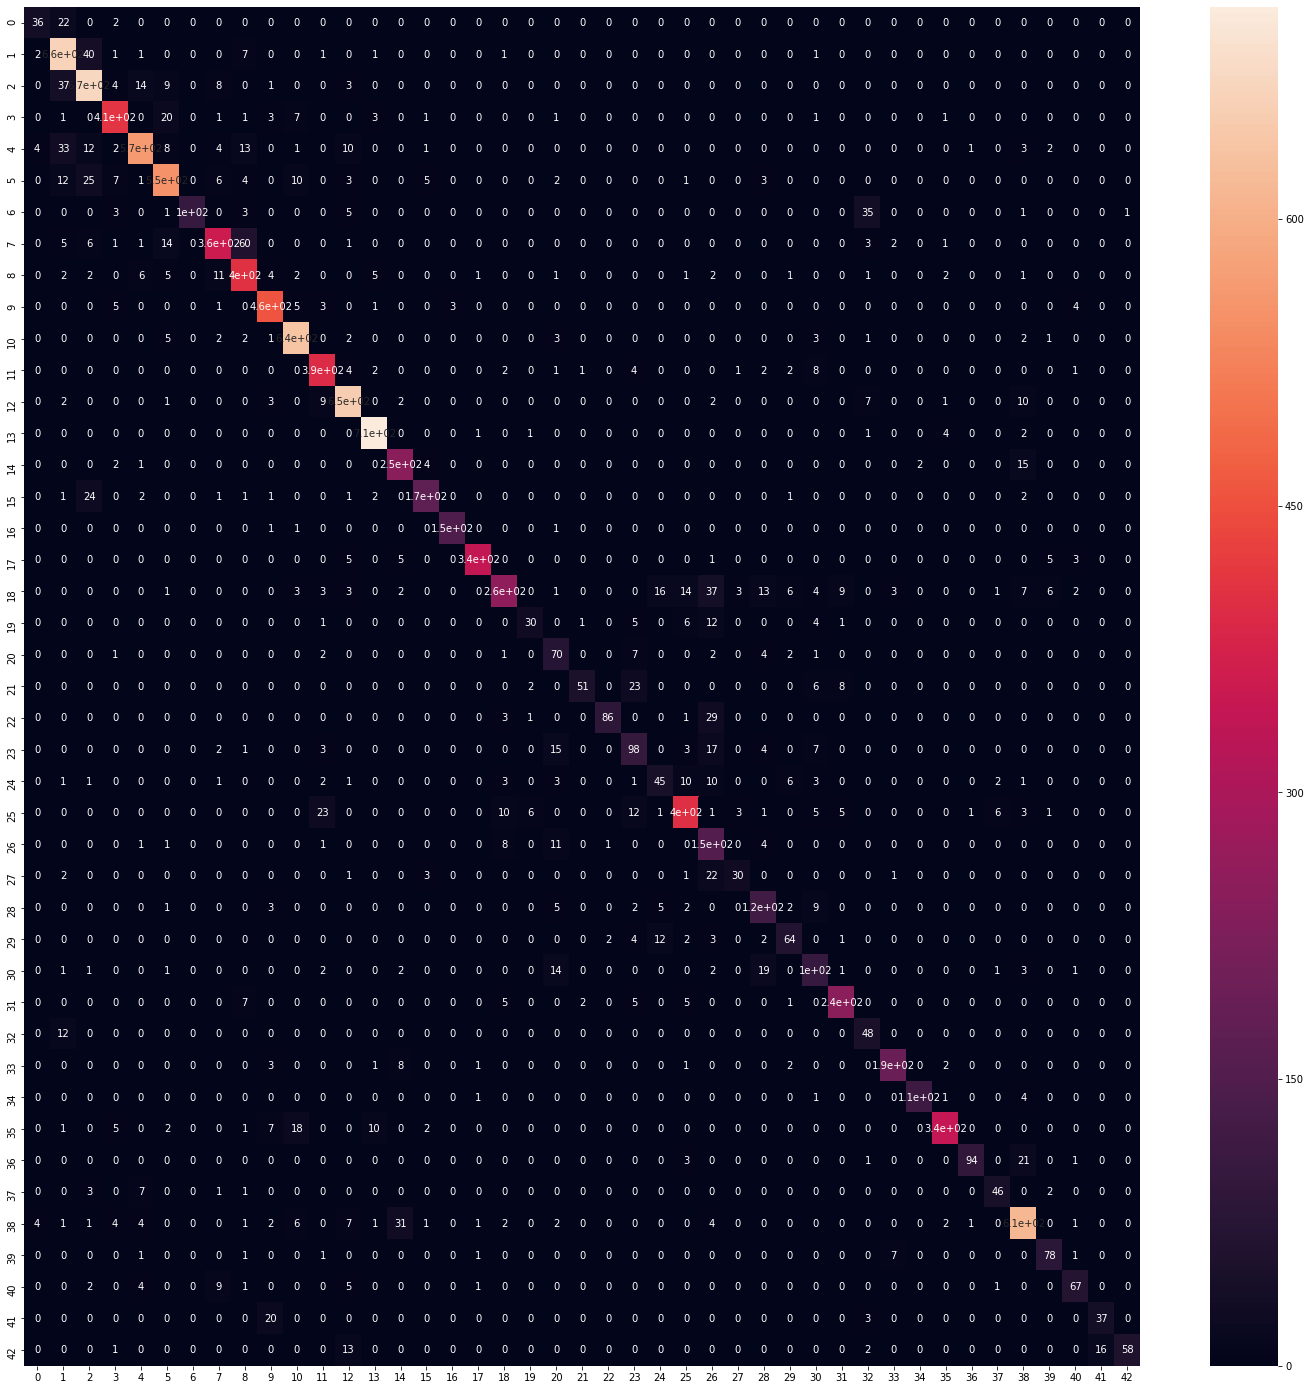

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)#Create the confusion matrix
plt.figure(figsize = (25, 25))#Set the size
sns.heatmap(cm, annot = True);#Show the map

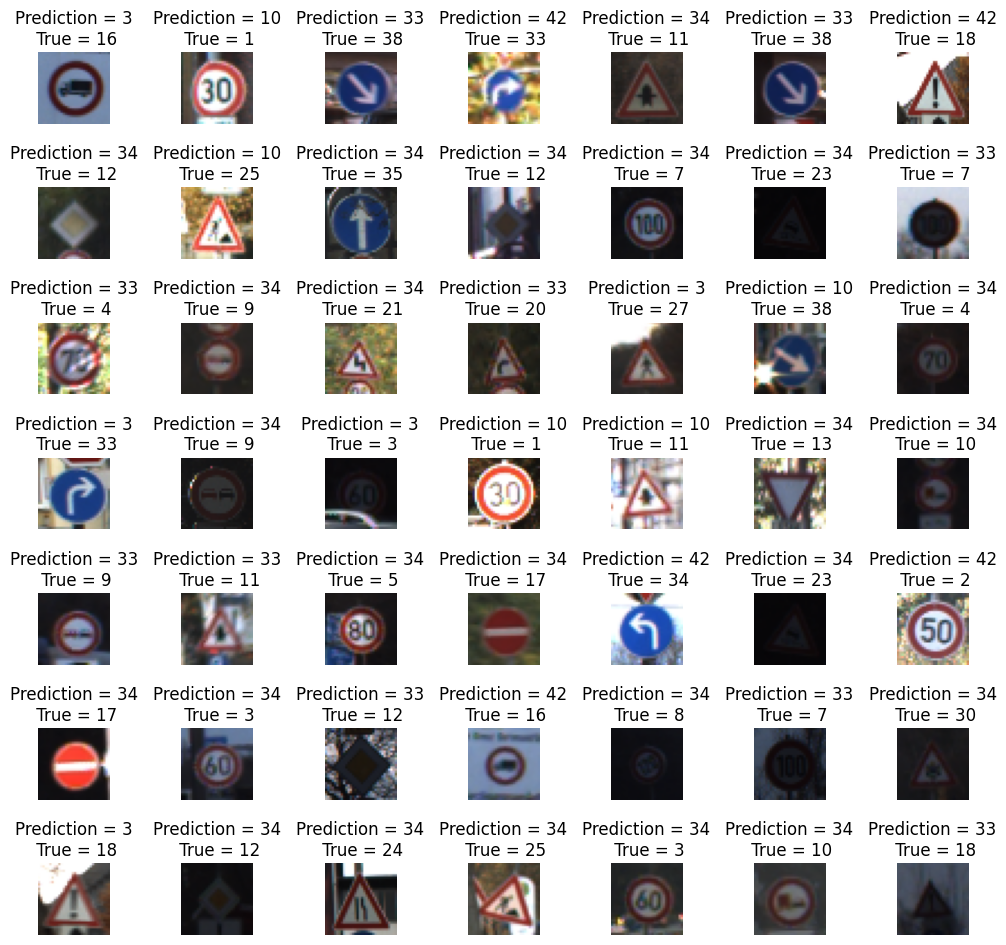

In [ ]:
L = 7
W = 7

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(predicted_classes[i], y_true[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)